In [1]:
from __future__ import division
import numpy as np
import scipy as sp
import cPickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h3>Optimization</h3>
For a random weight vector W, lets see what our loss function looks like in one or two dimensions by holding all weights except one or two constant

In [2]:
files = ['cifar-10-batches-py/data_batch_' + str(i) for i in range(1, 6)]
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

batches = map(unpickle, files)
X = np.concatenate([b['data'] for b in batches])
X = (X.astype(float) - 127) / 255
y = np.concatenate([b['labels'] for b in batches])

X_test = map(unpickle, ['cifar-10-batches-py/test_batch'])[0]['data']
X_test = (X_test.astype(float) - 127) / 255
y_test = map(unpickle, ['cifar-10-batches-py/test_batch'])[0]['labels']

In [4]:
W = 0.01 * np.random.randn(10, 3072)
b = 0.01 * np.random.randn(10, 1)

def hinge_loss(X, y, W, b, delta=10):
    L = np.dot(W, X.T) + b
    Correct = L.T[[i for i in xrange(len(L[0]))], y]
    R = L.T - Correct[:, np.newaxis] + delta
    R[[i for i in xrange(len(R))], y] = 0
    return np.sum(R)

In [53]:
# We'll modify the values of W_1,23 and W_1,563
weight_1 = np.linspace(-1, 1, 20)
weight_2 = np.linspace(-1, 1, 20)
errors = np.zeros((10, 10))

for i in xrange(10):
    for j in xrange(10):
        W[:, 230] = weight_1[i]
        W[:, 163] = weight_2[j]
        errors[i, j] = hinge_loss(X, y, W, b) + 0.1 * np.sum(W**2)

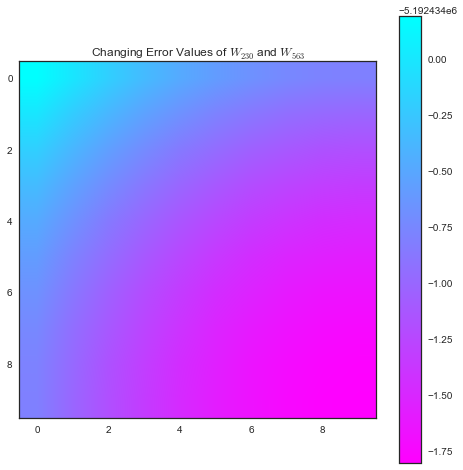

In [54]:
sns.set_style("white")
plt.figure(figsize=(8,8))
plt.imshow((errors - np.mean(errors)/np.std(errors)), cmap="cool_r")
plt.colorbar()
plt.title("Changing Error Values of $W_{230}$ and $W_{563}$")
plt.show()

In [34]:
errors = np.zeros((40, 1))
for i, value in enumerate(np.linspace(-20, 20, 40)):
    W[:, 263] = value
    errors[i] = hinge_loss(X, y, W, b) + 0.1 * np.sum(W**2)

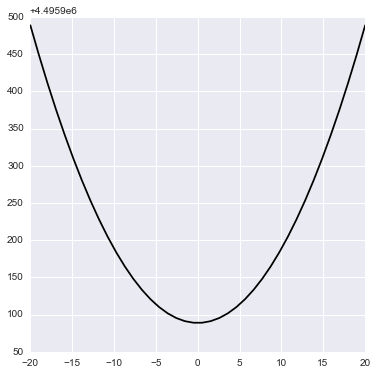

In [36]:
sns.set_style("darkgrid")
plt.figure(figsize=(6, 6))
plt.plot(np.linspace(-20, 20, 40), errors, color="black")
plt.show()

<h3>Convex Optimization</h3>
Already know a fair bit about this - going to skip past the random search onto gradient stuff 


<h3>Gradient Based Optimization</h3>
The method of steepest descent - the derivative of a function $f(x)$ gives us the slope which tells us the direction to travel to mimimize it (negative slope).  For a multivariate function $f(x_1, x_2, ..., x_p)$ the vector of partial derivatives known as the gradient $\nabla f = [\frac{\partial f}{\partial x_1}, ..., \frac{\partial f}{\partial x_p} ]$.  Traveling in the opposite direction of the gradient will take us to the function minimum.  Note that in our case the function we are differentiating is our loss function with respect to the weights $w_i$.  Not all loss functions are fully differentiable, so we will sometimes use the subgradient.

The general update rule is 

$$W = W - \eta \nabla f $$

Where W is our vector of weights, $\nabla f$ is the vector of partial derivative of the loss function, and $\eta$ is our step size

In [75]:
f = lambda x1, x2: 4 * x1**2 + x2**2 
x1_domain = np.linspace(-20, 20, 100)
x2_domain = np.linspace(-20, 20, 100)
ranges = np.zeros((100, 100))
for i, x1 in enumerate(x1_domain):
    for j, x2 in enumerate(x2_domain):
        ranges[i][j] = f(x1, x2)

In [94]:
step = 0.0001
df_x1 = lambda x1: 8 * x1
df_x2 = lambda x2: 2 * x2
W = np.array([-20, -20])
steps = np.zeros((40, 2))
steps[0] = W
for i in xrange(1, 40):
    W[0] = W[0] - step * df_x1(W[0])
    W[1] = W[1] - step * df_x2(W[1])
    steps[i] = W

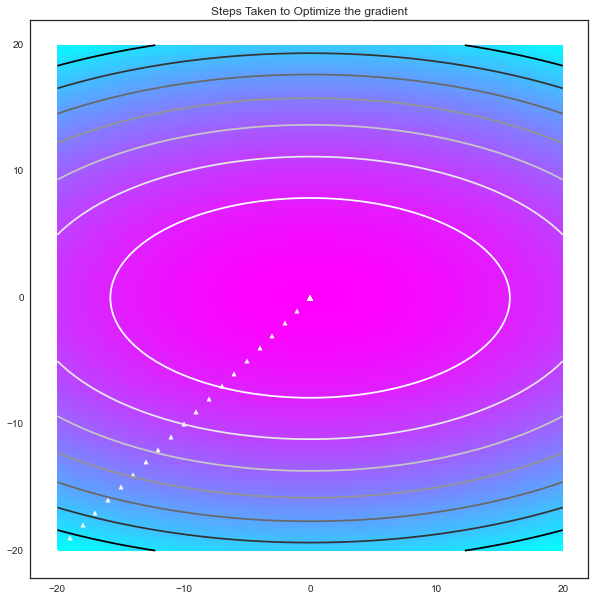

In [96]:
plt.figure(figsize=(10,10))
plt.contour(x1_domain, x2_domain, ranges)
plt.pcolormesh(x1_domain, x2_domain, ranges, cmap = plt.get_cmap('cool_r'))
plt.scatter(steps[:, 0], steps[:, 1], color="white", marker="^")
plt.title("Steps Taken to Optimize the gradient")
plt.show()

Note that if your stepsize is too large, you will overshoot the minimum and bounce around chaotically.  If it is set too small, you will never reach the minimum


<h3>Finding a Better Weight Vector for our Linear Model</h3>

The derivative of our loss function with respect to the weights is

$$L_i = \sum_{j \neq y}[max(0, w^T_j x_i - w^T_{y_i}x_i + \Delta)] $$

$$\nabla_{w_{y_i}} L_i = -(\sum_{j \neq y}I[w^T_j x_i - w_{y_i}x_i + \Delta > 0])x_i $$

Where $I$ is the indicator function.  Note that this only for rows of $W$ which correspond to the correct class.  For the other rows, the derivative is

$$\nabla_{w_{j}} L_i = I(w^T_j x_i - w_{y_i}x_i + \Delta > 0)x_i $$